# Hotdog / Not Hotdog Classification

https://drive.google.com/file/d/1FZ3ZwcPDoEave_xp50Ziue39gMhGPO1W/view

## Imports

In [1]:
from math import ceil

import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)

from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img,
)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Using TensorFlow backend.


## Data pre-processing and augmentation

We'll generate some pictures using keras ImageDataGenerator to get a sense of how augmentation will be working in our training pipeline.

Base image:


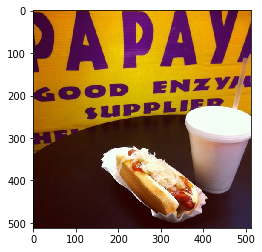

Augmented images:


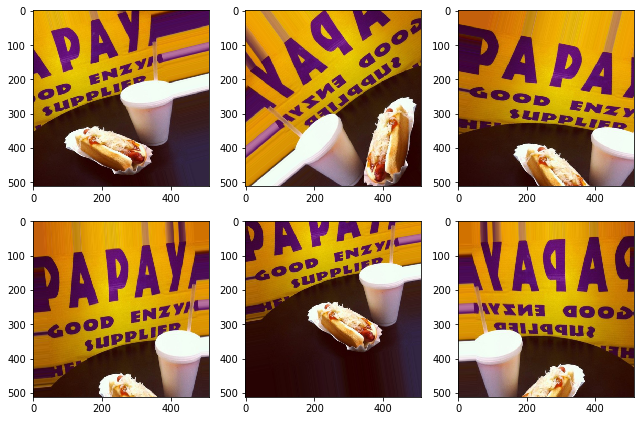

In [2]:
base_image = load_img("data/train/hot_dog/1000288.jpg")  # a PIL image
print("Base image:")
plt.imshow(base_image)
plt.show()

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
x = img_to_array(base_image)  # a numpy array of shape (512, 512, 3)
x = x.reshape((1,) + x.shape)  # a numpy array of shape (1, 512, 512, 3)
image_gen = datagen.flow(x, batch_size=1)

fig = plt.figure(figsize=(9, 6))
gs = GridSpec(nrows=2, ncols=3)
print("Augmented images:")
for i in range(6):
    ax = fig.add_subplot(gs[i])
    aug_image = image_gen.next()[0]
    ax.imshow(array_to_img(aug_image))
fig.tight_layout()

## Training a small convnet from scratch

Our first model is a simple stack of 3 convolution layers with a ReLU activation followed by max-pooling layers. On top of it we add two fully-connected layers. We end the model with a single unit and a sigmoid activation for binary classification. To go with it we will also use the `binary_crossentropy` loss to train our model.

In [3]:
model = Sequential()
model.add(
    Conv2D(
        32,
        (3, 3),
        input_shape=(32, 32, 1),
        activation="relu",
        kernel_initializer="he_normal",
    )
)
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

adam = Adam(lr=1e-4)
model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])

Let's prepare our data. We will use .flow_from_directory() to generate batches of image data and their labels directly from our jpgs in their respective folders.

As a part of image processing we will apply rescale transformation. Below ImageDataGenerator's `rescale` parameter is a value by which we will multiply the data before any other processing. Our original images consist of RGB coefficients in the 0-255, but such values would be too high for our models to process given a typical learning rate, so we target values between 0 and 1 instead by scaling with a 1/255 factor.

In [4]:
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=360,
    zoom_range=0.2,
    horizontal_flip=True,
)

# a generator that will read pictures found in subfolers of 'data/train'
# and indefinitely generate batches of augmented image data.
train_generator = datagen.flow_from_directory(
    "data/train", target_size=(32, 32), batch_size=batch_size, class_mode="binary", color_mode="grayscale"
)

# a similar generator for validation data
validation_generator = datagen.flow_from_directory(
    "data/test", target_size=(32, 32), batch_size=batch_size, class_mode="binary", color_mode="grayscale"
)

Found 541 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


We can now use these generators to train our model. We will use a simple checkpointing strategy to save the best weights of our model. We will also use TensorBoard callback for visualization of training process.

In [5]:
es = EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)

checkpoint_path = "auxiliary/model.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor="val_acc", verbose=1, save_best_only=True, mode="max"
)

tensorboard = TensorBoard(log_dir="auxiliary/logs", write_graph=True, write_images=True)

model.fit_generator(
    train_generator,
    steps_per_epoch=ceil(541 / batch_size) * 60,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=ceil(500 / batch_size) * 16,
    callbacks=[es, checkpoint, tensorboard],
)

Epoch 1/100
1020/1020 [==============================] - 164s 161ms/step - loss: 0.7076 - acc: 0.5398 - val_loss: 0.6859 - val_acc: 0.5604

Epoch 00001: val_acc improved from -inf to 0.56038, saving model to auxiliary/model.h5
Epoch 2/100
1020/1020 [==============================] - 161s 158ms/step - loss: 0.6754 - acc: 0.5764 - val_loss: 0.6786 - val_acc: 0.5744

Epoch 00002: val_acc improved from 0.56038 to 0.57438, saving model to auxiliary/model.h5
Epoch 3/100
1020/1020 [==============================] - 153s 150ms/step - loss: 0.6626 - acc: 0.6009 - val_loss: 0.6708 - val_acc: 0.5723

Epoch 00003: val_acc did not improve from 0.57438
Epoch 4/100
1020/1020 [==============================] - 150s 147ms/step - loss: 0.6489 - acc: 0.6219 - val_loss: 0.6616 - val_acc: 0.5915

Epoch 00004: val_acc improved from 0.57438 to 0.59150, saving model to auxiliary/model.h5
Epoch 5/100
1020/1020 [==============================] - 155s 152ms/step - loss: 0.6417 - acc: 0.6312 - val_loss: 0.6571 - 